# Tutorial 2: Generative Adversarial Networks template in generating handwritting numbers

## **1. import packages**

In [16]:
from __future__ import print_function
#%matplotlib inline
import random
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision import datasets # Training dataset
from torchvision.utils import make_grid
from torchvision import utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import numpy as np

import matplotlib.animation as animation
from IPython.display import HTML
import time

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("My device: => ", device)

# Set random seed for reproducibility
my_seed = 123
random.seed(my_seed)
torch.manual_seed(my_seed);

My device: =>  cuda:0


## **2. download MNIST dataset**

In [17]:
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])

data_train = datasets.MNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## **3. Plot the dataset number with its shape**

The shape of the images dataset is:torch.Size([128, 1, 28, 28])
The shape of the labels dataset is:torch.Size([128])


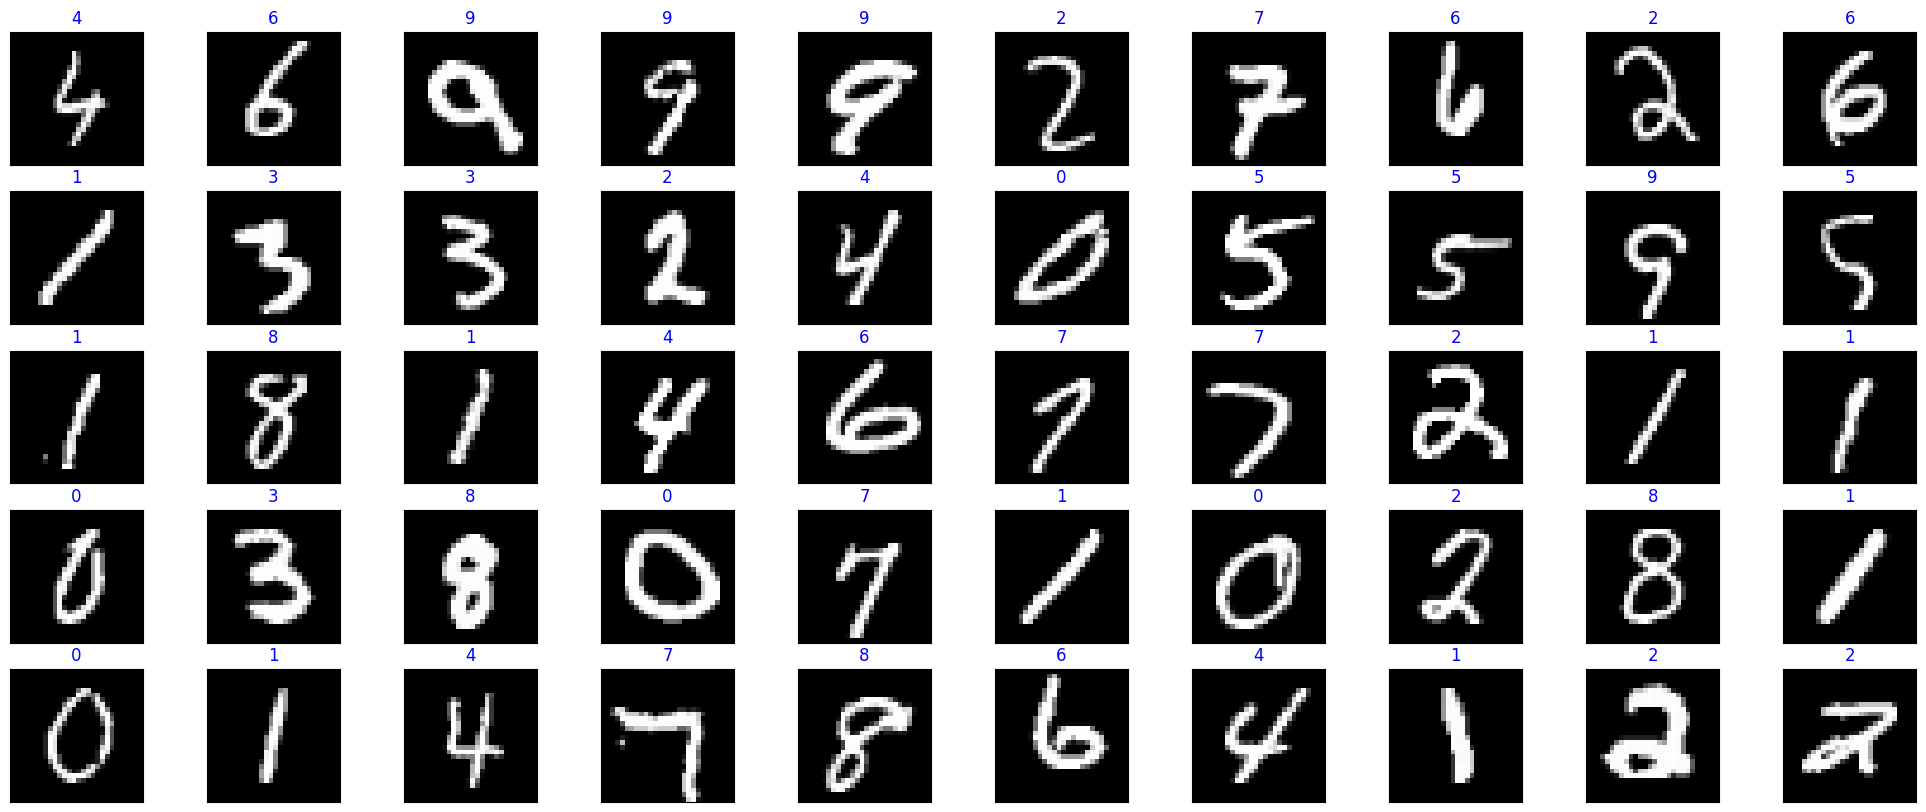

In [35]:
classes = ['0','1','2','3','4','5','6','7','8','9']

dataiter = iter(train_loader)
images, labels = next(dataiter)
images_arr = []
labels_arr = []

image_number  = 50
row_numer = 5
collumn_number = 10


for i in range(0, image_number):
  images_arr.append(images[i].unsqueeze(0))
  labels_arr.append(labels[i].item())

fig = plt.figure(figsize=(25, 10))
for i in range(image_number):
  ax = fig. add_subplot(row_numer, collumn_number, i+1, xticks=[], yticks=[])
  ax.imshow(images_arr[i].resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
  ax.set_title("{}".format(classes[labels_arr[i]]), color=("blue"))
print('The shape of the images dataset is:'+ str(images.shape))
print('The shape of the labels dataset is:'+ str(labels.shape))

## **4. The generator block neural network architecture**

In [40]:
class Generator(nn.Module):
  def __init__(self, z_dim=10, img_dim=28*28, hidden_dim=128):
    super(Generator, self).__init__()

    self.gen = nn.Sequential(
        get_generator_block(z_dim, hidden_dim),
        get_generator_block(hidden_dim, hidden_dim * 2),
        get_generator_block(hidden_dim * 2, hidden_dim * 4),
        get_generator_block(hidden_dim * 4, hidden_dim * 8),
        nn.Linear(hidden_dim * 8, img_dim),
        nn.Sigmoid(),
    )

  def forward(self, noise):
    gen_output = self.gen(noise)
    return gen_output

def get_generator_block(input_dim, output_dim):
  seq = nn.Sequential(
      nn.Linear(input_dim, output_dim),
      nn.BatchNorm1d(output_dim),
      nn.LeakyReLU(negative_slope=0.2, inplace=False),
      nn.Dropout(0.3),
  )
  return seq


def get_generator_noise(n_sample, z_dim, device='cpu'):
  my_noise = torch.randn(n_sample, z_dim, device=device)
  return my_noise

## **5. The discriminator block neural network architecture**

In [41]:
# Discriminator Class:

class Discriminator(nn.Module):
  def __init__(self, img_dim=28*28, hidden_dim=128):
    super(Discriminator, self).__init__()

    self.disc = nn.Sequential(
        get_discriminator_block(img_dim, hidden_dim * 4),
        get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
        get_discriminator_block(hidden_dim * 2, hidden_dim),
        nn.Linear(hidden_dim, 1),
    )

  def forward(self, image):
    state = self.disc(image)
    return state

def get_discriminator_block(input_dim, output_dim):
  seq = nn.Sequential(
      nn.Linear(input_dim, output_dim),
      nn.LeakyReLU(negative_slope=0.2, inplace=False),
  )
  return seq

## **6. Hyperparameters basic setting or loss function, epochs, learning rate etc.**

In [42]:
# Set your parameters

criterion = nn.BCEWithLogitsLoss()
num_epochs = 100
z_dim = 64
display_step = 1000
lr = 0.0001

size = (1, 28, 28)

device = 'cuda'

## **7. Generator and discriminator blocks initializing**

In [43]:
# Generator:
generator = Generator(z_dim).to(device)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

# Discriminator:
discriminator = Discriminator().to(device)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

## **8. Initializing the loss calculation function of generator and discriminator**

In [44]:
# Discriminator Loss:
def get_discriminator_loss(gen, disc, criterion, real, num_images, z_dim, device):
  noise = get_generator_noise(num_images, z_dim, device=device)
  gen_output = gen(noise)
  disc_out_fake = disc(gen_output.detach())
  disc_loss_fake = criterion(disc_out_fake, torch.zeros_like(disc_out_fake))
  disc_out_real = disc(real)
  disc_loss_real = criterion(disc_out_real, torch.ones_like(disc_out_real))

  disc_loss = (disc_loss_fake + disc_loss_real) / 2
  return disc_loss
# Generator Loss:
def get_generator_loss(gen, disc, criterion, num_images, z_dim, device):
  noise = get_generator_noise(num_images, z_dim, device=device)
  gen_output = gen(noise)
  disc_preds = disc(gen_output) # gen_output.detach()
  gen_loss = criterion(disc_preds, torch.ones_like(disc_preds))

  return gen_loss

## **9. Images plot function**

In [45]:
# Show Images Function:

def show_tensor_images(real, fake, num_images=25, size=(1, 28, 28)):
  plt.figure(figsize=(15,15))
  image_unflat_real = real.detach().cpu().view(-1, *size)
  image_grid_real = make_grid(image_unflat_real[:num_images], nrow=5, normalize=True, padding=2)
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(image_grid_real.permute(1, 2, 0).squeeze())

  image_unflat_fake = fake.detach().cpu().view(-1, *size)
  image_grid_fake = make_grid(image_unflat_fake[:num_images], nrow=5, normalize=True, padding=2)
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(image_grid_fake.permute(1, 2, 0).squeeze())
  plt.show()

## **10. Training loop architecture of the GAN model**

In [ ]:
# Training Loop

img_list = []
G_losses = []
D_losses = []

iters = 0
cur_step = 0
img_show = 3

mean_generator_loss = 0
mean_discriminator_loss = 0
start_time= time.time()
for epoch in range(num_epochs):

  for real, _ in tqdm(train_loader):
    cur_batch_size = len(real)

    real = real.view(cur_batch_size, -1).to(device)

    disc_optimizer.zero_grad()

    disc_loss = get_discriminator_loss(generator, discriminator, criterion, real, cur_batch_size, z_dim, device)

    disc_loss.backward()

    disc_optimizer.step()


    gen_optimizer.zero_grad()
    gen_loss = get_generator_loss(generator, discriminator, criterion, cur_batch_size, z_dim, device)
    gen_loss.backward()
    gen_optimizer.step()

    mean_discriminator_loss += disc_loss.item() / cur_batch_size
    mean_generator_loss += gen_loss.item() / cur_batch_size

    G_losses.append(mean_discriminator_loss)
    D_losses.append(mean_generator_loss)


    if cur_step % display_step == 10 and cur_step >= 0:
      print(f"[Epoch: {epoch}/{num_epochs}] | [Step: {cur_step}/{num_epochs*len(train_loader)}], Generator Loss: {mean_generator_loss}, Discriminator Loss: {mean_discriminator_loss}")
      fake_noise = get_generator_noise(cur_batch_size, z_dim, device=device)
      fake = generator(fake_noise)

      img_list.append(make_grid(fake.detach().cpu().view(-1, *size)[:36], nrow=6, normalize=True, padding=2))
      mean_discriminator_loss = 0
      mean_generator_loss = 0

    cur_step += 1

  #if epoch % img_show == 0:
  #  fake_noise = get_generator_noise(cur_batch_size, z_dim, device=device)
  #  fake = generator(fake_noise)
  #  show_tensor_images(real, fake)

end= time.time() - start_time
print('time for train: ', end/3600 , 'hours')

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 0/100] | [Step: 0/46900], Generator Loss: 0.005875956267118454, Discriminator Loss: 0.005397404544055462


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 2/100] | [Step: 1000/46900], Generator Loss: 48.062444665158786, Discriminator Loss: 0.7707629036037057


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 4/100] | [Step: 2000/46900], Generator Loss: 48.210830096776284, Discriminator Loss: 0.2050932716859582


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 6/100] | [Step: 3000/46900], Generator Loss: 52.58156001816193, Discriminator Loss: 0.3060884649761041


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 8/100] | [Step: 4000/46900], Generator Loss: 49.091801592459284, Discriminator Loss: 0.37248664159172523


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 10/100] | [Step: 5000/46900], Generator Loss: 46.11356114347775, Discriminator Loss: 0.4275642564643931


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 12/100] | [Step: 6000/46900], Generator Loss: 44.95252237344782, Discriminator Loss: 0.39402902805886697


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 14/100] | [Step: 7000/46900], Generator Loss: 41.34816256041328, Discriminator Loss: 0.5143456768103837


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 17/100] | [Step: 8000/46900], Generator Loss: 40.99256470426917, Discriminator Loss: 0.5013744605627533


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 19/100] | [Step: 9000/46900], Generator Loss: 38.21168027445675, Discriminator Loss: 0.6193072894190361


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 21/100] | [Step: 10000/46900], Generator Loss: 36.81553950843711, Discriminator Loss: 0.6375649788581843


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 23/100] | [Step: 11000/46900], Generator Loss: 36.804832593227424, Discriminator Loss: 0.6515124611808764


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 25/100] | [Step: 12000/46900], Generator Loss: 37.12729467141132, Discriminator Loss: 0.6463027828382717


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 27/100] | [Step: 13000/46900], Generator Loss: 34.71572104717294, Discriminator Loss: 0.7212035794703601


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 29/100] | [Step: 14000/46900], Generator Loss: 33.16367530388136, Discriminator Loss: 0.8416657700824242


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 31/100] | [Step: 15000/46900], Generator Loss: 31.730209348723296, Discriminator Loss: 0.8595032369485125


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 34/100] | [Step: 16000/46900], Generator Loss: 29.587285943950217, Discriminator Loss: 1.0187475989514496


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 36/100] | [Step: 17000/46900], Generator Loss: 28.848397836710017, Discriminator Loss: 1.0638663292532633


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 38/100] | [Step: 18000/46900], Generator Loss: 27.357841697211068, Discriminator Loss: 1.1651722442475148


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 40/100] | [Step: 19000/46900], Generator Loss: 26.83136998862028, Discriminator Loss: 1.1880042862806781


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 42/100] | [Step: 20000/46900], Generator Loss: 25.92894301066796, Discriminator Loss: 1.2715621048895023


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 44/100] | [Step: 21000/46900], Generator Loss: 25.371235004315775, Discriminator Loss: 1.349610314394037


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 46/100] | [Step: 22000/46900], Generator Loss: 24.56639669276774, Discriminator Loss: 1.407486222742591


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 49/100] | [Step: 23000/46900], Generator Loss: 23.49730009399354, Discriminator Loss: 1.4848535610556912


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 51/100] | [Step: 24000/46900], Generator Loss: 23.46282856166363, Discriminator Loss: 1.49469367628141


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 53/100] | [Step: 25000/46900], Generator Loss: 22.630052865172427, Discriminator Loss: 1.573782798969963


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 55/100] | [Step: 26000/46900], Generator Loss: 22.264309308181204, Discriminator Loss: 1.6031016770284623


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 57/100] | [Step: 27000/46900], Generator Loss: 22.095339184626937, Discriminator Loss: 1.6200907001039013


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 59/100] | [Step: 28000/46900], Generator Loss: 21.470665459831555, Discriminator Loss: 1.6803820757195354


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 61/100] | [Step: 29000/46900], Generator Loss: 21.40443332555393, Discriminator Loss: 1.6842133975587783


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 63/100] | [Step: 30000/46900], Generator Loss: 21.27955305731545, Discriminator Loss: 1.6923648550679595


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 66/100] | [Step: 31000/46900], Generator Loss: 21.32350576203316, Discriminator Loss: 1.701021734450478


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 68/100] | [Step: 32000/46900], Generator Loss: 21.178301436205704, Discriminator Loss: 1.7135549530697365


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 70/100] | [Step: 33000/46900], Generator Loss: 21.176968129662175, Discriminator Loss: 1.7198420217027888


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 72/100] | [Step: 34000/46900], Generator Loss: 21.15639945057531, Discriminator Loss: 1.7124735892672713


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 74/100] | [Step: 35000/46900], Generator Loss: 21.354665925726295, Discriminator Loss: 1.695623471828488


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 76/100] | [Step: 36000/46900], Generator Loss: 21.28371596367409, Discriminator Loss: 1.693644405071003


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 78/100] | [Step: 37000/46900], Generator Loss: 21.43958719447255, Discriminator Loss: 1.686473383529422


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 81/100] | [Step: 38000/46900], Generator Loss: 21.407767673954368, Discriminator Loss: 1.7039857157117997


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 83/100] | [Step: 39000/46900], Generator Loss: 21.476555469445884, Discriminator Loss: 1.6882797498449993


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 85/100] | [Step: 40000/46900], Generator Loss: 21.672536430259544, Discriminator Loss: 1.6757684699259696


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 87/100] | [Step: 41000/46900], Generator Loss: 21.761794998310506, Discriminator Loss: 1.675173758179881


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 89/100] | [Step: 42000/46900], Generator Loss: 21.617554462204378, Discriminator Loss: 1.6716508163372055


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 91/100] | [Step: 43000/46900], Generator Loss: 21.68294477680077, Discriminator Loss: 1.6551617682756237


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 93/100] | [Step: 44000/46900], Generator Loss: 21.97520142669479, Discriminator Loss: 1.6481806285640537


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 95/100] | [Step: 45000/46900], Generator Loss: 22.006194876196485, Discriminator Loss: 1.6353971781015084


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 98/100] | [Step: 46000/46900], Generator Loss: 22.24384050971518, Discriminator Loss: 1.610039415109592


  0%|          | 0/469 [00:00<?, ?it/s]

time for train:  0.4445900250143475 hours


## **11. Results display**

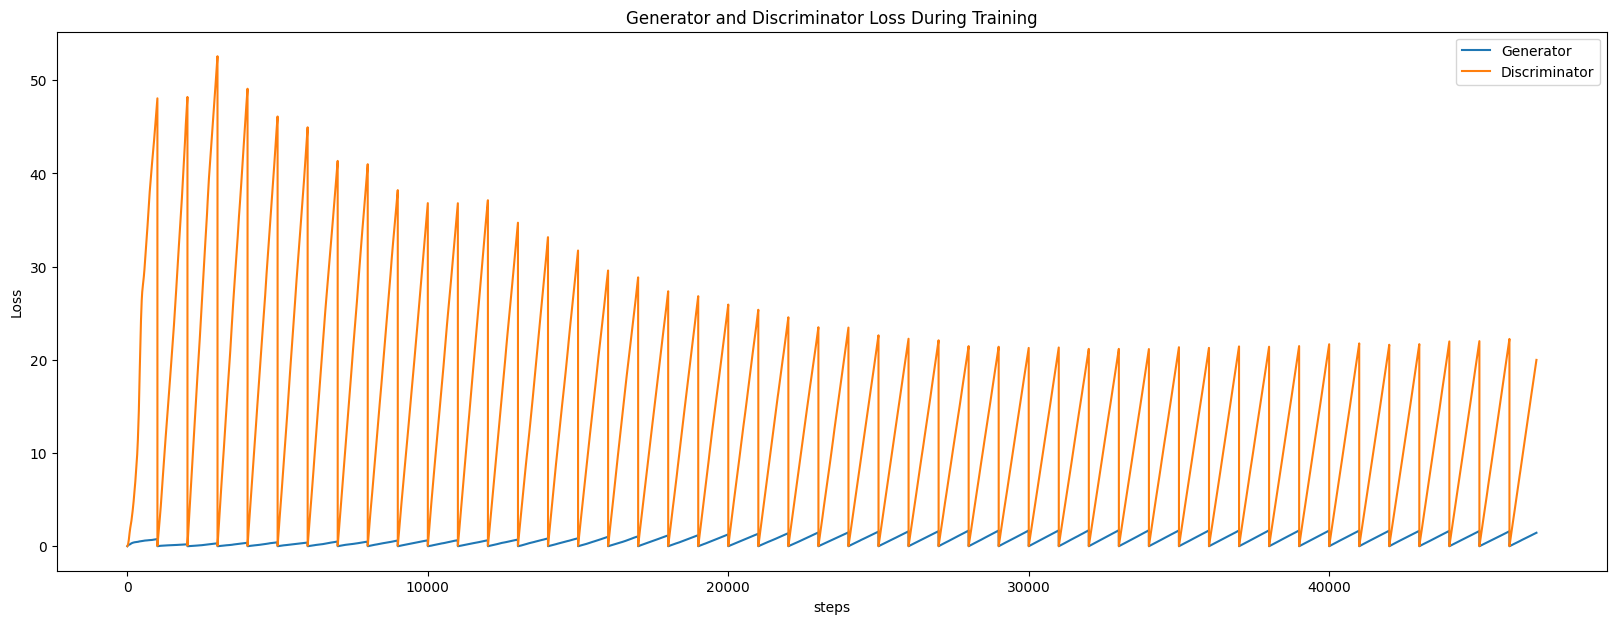

In [48]:
plt.figure(figsize=(20, 7))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

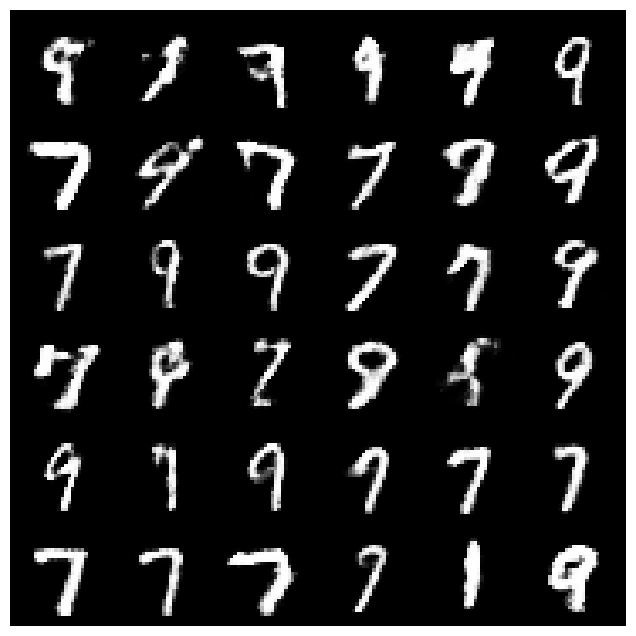

In [49]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
imgs = [[plt.imshow(np.transpose(img, (1,2,0)), animated=True)] for img in img_list]
anim = animation.ArtistAnimation(fig, imgs, interval=100, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())